In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier


In [2]:
# 1. Tải dữ liệu
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 1. Định nghĩa mô hình
# Lưu ý: 'algorithm' mặc định là SAMME.R (tốt hơn cho tính xác suất), ta giữ nguyên hoặc tune nếu cần
ada_boost = AdaBoostClassifier(random_state=42)

# 2. Định nghĩa lưới tham số (Đã bổ sung)
param_grid = {
    # Tăng số lượng cây để bù đắp nếu learning_rate thấp
    'n_estimators': [50, 100, 200, 300, 500],
    
    # Mở rộng learning rate để tìm điểm cân bằng (nhỏ thì học kỹ, lớn thì học nhanh)
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5],
    
    # QUAN TRỌNG: Tinh chỉnh bộ phân loại cơ sở (Base Estimator)
    # Mặc định AdaBoost dùng max_depth=1 (Stump). 
    # Ta thử thêm depth=2 và 3 để mô hình học được mối quan hệ phức tạp hơn giữa các genes/features.
    'estimator': [
        DecisionTreeClassifier(max_depth=1), # Mặc định (Stump)
        DecisionTreeClassifier(max_depth=2), # Phức tạp hơn chút
        DecisionTreeClassifier(max_depth=3)  # Cẩn thận overfitting nếu sâu quá
    ],
    
    # Thuật toán cập nhật trọng số (SAMME.R thường hội tụ nhanh hơn)
    'algorithm': ['SAMME', 'SAMME.R'] 
}

# 3. Thiết lập Grid Search
# n_jobs=-1 để chạy đa luồng cho nhanh
grid_search = GridSearchCV(estimator=ada_boost, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# 4. Fit mô hình
print("Đang tìm kiếm tham số tối ưu cho AdaBoost...")
grid_search.fit(X_train, y_train)

# 5. Kết quả
print("\n" + "="*40)
print("Best Parameters:", grid_search.best_params_)
print(f"Best Score (CV): {grid_search.best_score_:.4f}")
print("="*40)

# Kiểm tra trên tập Test (nếu có biến X_test, y_test từ các bước trước)
# from sklearn.metrics import accuracy_score
# best_ada = grid_search.best_estimator_
# print(f"Test Accuracy: {accuracy_score(y_test, best_ada.predict(X_test))*100:.2f}%")

Đang tìm kiếm tham số tối ưu cho AdaBoost...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorith


Best Parameters: {'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.5, 'n_estimators': 300}
Best Score (CV): 0.9592


In [6]:
best_model_ab = grid_search.best_estimator_
# Fit the best model on the training data

model_name = "AdaBoost"
y_pred_ab = best_model_ab.predict(X_test)

acc = accuracy_score(y_test, y_pred_ab)
print(f"\nĐộ chính xác (Accuracy) của {model_name}: {acc*100:.2f}%")
print("-" * 30)
print("Báo cáo chi tiết (Precision, Recall, F1-Score):")
print(classification_report(y_test, y_pred_ab))
print("-" * 30)
print(f'F1_Score: {classification_report(y_test, y_pred_ab, output_dict=True)["weighted avg"]["f1-score"]:.4f}')
print(f'Accuracy: {classification_report(y_test, y_pred_ab, output_dict=True)["accuracy"]:.4f}')


Độ chính xác (Accuracy) của AdaBoost: 98.21%
------------------------------
Báo cáo chi tiết (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.75      0.86         4

    accuracy                           0.98        56
   macro avg       0.99      0.88      0.92        56
weighted avg       0.98      0.98      0.98        56

------------------------------
F1_Score: 0.9810
Accuracy: 0.9821


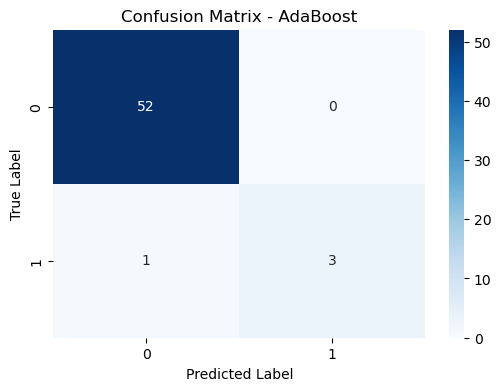

In [7]:
# 5. Vẽ Confusion Matrix (Tùy chọn để làm đẹp báo cáo)
cm = confusion_matrix(y_test, y_pred_ab)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()